This example is taken from:

[Simple Bayesian Network via MCMC](https://bugra.github.io/work/notes/2014-05-23/simple-bayesian-network-via-monte-carlo-markov-chain-mcmc-pymc/)

[A Github gist by Christian Schuhegger](https://gist.github.com/cs224/9a19b4ba2c7511e317be90c32a4d40d7)

This is a demonstration of bayesian network from a famous rain/sprinkler/grass problem. Here's the problem statement from the [Wikipedia page of Baye's Network](https://en.wikipedia.org/wiki/Bayesian_network).

> Suppose that there are two events which could cause grass to be wet: either the sprinkler is on or it's raining. Also, suppose that the rain has a direct effect on the use of the sprinkler (namely that when it rains, the sprinkler is usually not turned on). Then the situation can be modeled with a Bayesian network (shown to the right). All three variables have two possible values, T (for true) and F (for false).

In [1]:
from IPython.display import Image
Image(url='http://upload.wikimedia.org/wikipedia/commons/0/0e/SimpleBayesNet.svg')

To model the situation with Bayesian Network, we use `pymc3`, an awesome Python library for probabilistic learning. You can read more about this library in the [documentation](https://pymc-devs.github.io/pymc3/index.html).

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import pymc3 as pm

niter = 20000  # 10000
tune = 5000  # 5000


`pymc3` requires us to generate a Model variable and use the syntax `with model:` to create context. When we run the code inside the `with model` block, the variables will be automatically assigned to the model.

100%|██████████| 20000/20000 [00:06<00:00, 3035.98it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x110495b38>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x11131b470>]], dtype=object)

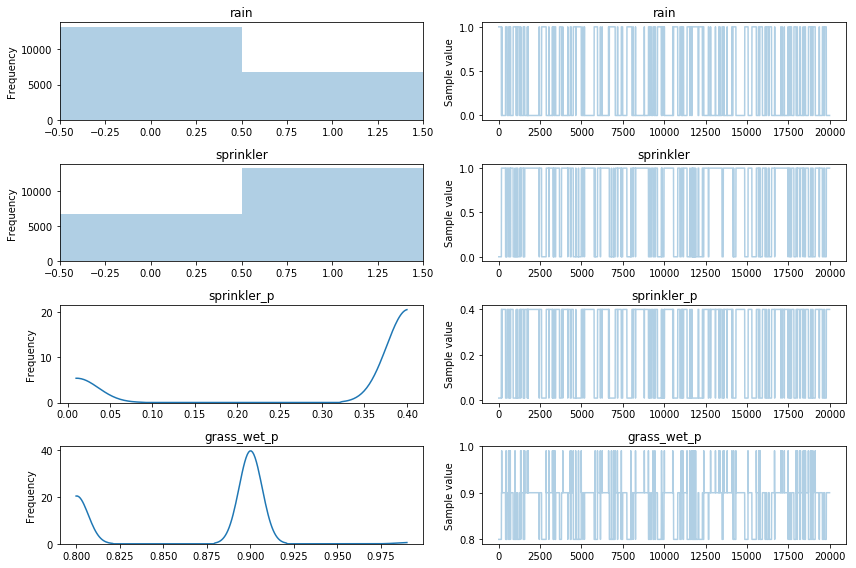

In [7]:
model = pm.Model()

with model:
    tv = [1]
    # create variable rain as a Bernoulli variable with probability to be True = 0.2
    # Bernoulli variable is binary (can only 0 or 1)
    rain = pm.Bernoulli('rain', 0.2, shape=1, testval=tv)
    
    # create variable sprinkler_p which equals to 
    # 0.01 if rain = 1 
    # 0.40 if rain = 0
    sprinkler_p = pm.Deterministic('sprinkler_p', pm.math.switch(rain, 0.01, 0.40))
    
    # sprinkler is a Bernoulli variable with probability of sprinkle_p
    sprinkler = pm.Bernoulli('sprinkler', sprinkler_p, shape=1, testval=tv)
    
    # grass_wet_p is another probability variable.
    # if rain is 1, grass_wet_p=0.99 if sprinkler = 1
    #               grass_wet_p=0.80 if sprinkler = 0
    # if rain is 0, grass_wet_p=0.90 if sprinkler = 1
    #               grass_wet_p=0.0 if sprinkler = 0
    grass_wet_p = pm.Deterministic('grass_wet_p', 
                                   pm.math.switch(rain, pm.math.switch(sprinkler, 0.99, 0.80), 
                                                  pm.math.switch(sprinkler, 0.90, 0.0)))
    
    # then we create a Bernoulli variable grass_wet
    grass_wet = pm.Bernoulli('grass_wet', grass_wet_p, observed=np.array([1]), shape=1)
    
    # given the bayesian network we just defined for pymc3, we ask pymc3 to generate samples
    trace = pm.sample(niter, step=[pm.BinaryGibbsMetropolis([rain, sprinkler])], tune=tune, random_seed=124)

pm.traceplot(trace)

#### After generating 20,000 sample events from the Bayesian network, let me put all these events in a table

In [19]:
dictionary = {
              'Rain': [1 if ii[0] else 0 for ii in trace['rain'].tolist() ],
              'Sprinkler': [1 if ii[0] else 0 for ii in trace['sprinkler'].tolist() ],
              'Sprinkler Probability': [ii[0] for ii in trace['sprinkler_p'].tolist()],
              'Grass Wet Probability': [ii[0] for ii in trace['grass_wet_p'].tolist()],
              }
df = pd.DataFrame(dictionary)

print('Shape of the table:')
print(df.shape)
print('\nSample Rows\n')
print(df.head())

Shape of the table:
(20000, 4)

Sample Rows

   Grass Wet Probability  Rain  Sprinkler  Sprinkler Probability
0                    0.8     1          0                   0.01
1                    0.8     1          0                   0.01
2                    0.8     1          0                   0.01
3                    0.8     1          0                   0.01
4                    0.8     1          0                   0.01


#### Great, we have so many samples of the events now we can do inference by using all these data

For example, I want to know that if grass is wet, what's the probability that it has rained.

In [22]:
p_rain_wet = float(df[(df['Rain'] == 1) & (df['Grass Wet Probability'] > 0.5)].shape[0]) / df[df['Grass Wet Probability'] > 0.5].shape[0] 
print(p_rain_wet)

0.3426
